In [1]:
from os import listdir
from os.path import isdir, join
from tensorflow.keras import layers, models
import tensorflow as tf
import numpy as np

In [2]:
# Create list of all targets (minus background noise)
# set dataset path
dataset_path = './data_speech_commands_v002'
all_targets = all_targets = [name for name in listdir(dataset_path) if isdir(join(dataset_path, name))]
all_targets.remove('_background_noise_')
print(all_targets)

['nine', 'eight', 'bed', 'bird', 'no', 'house', 'go', 'zero', 'marvin', 'dog', 'off', 'happy', 'stop', 'left', 'two', 'yes', 'on', 'learn', 'three', 'wow', 'tree', 'cat', 'right', 'down', 'six', 'five', 'backward', 'sheila', 'one', 'up', 'follow', 'visual', 'forward', 'seven', 'four']


In [3]:
# Settings
feature_sets_path = './'
feature_sets_filename = 'all_targets_mfcc_sets.npz'
model_filename = 'wake_word_stop_model.h5'
wake_word = 'stop'

In [4]:
# Load feature sets
feature_sets = np.load(join(feature_sets_path, feature_sets_filename))
print(feature_sets.files)

['x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test']


In [5]:
# Assign feature sets
x_train = feature_sets['x_train']
y_train = feature_sets['y_train']
x_val = feature_sets['x_val']
y_val = feature_sets['y_val']
x_test = feature_sets['x_test']
y_test = feature_sets['y_test']

In [6]:
# Look at tensor dimensions
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(77497, 16, 16)
(9670, 16, 16)
(9689, 16, 16)


In [7]:
# Peek at labels
print(y_val)

[12. 34. 30. ... 19. 18. 32.]


In [8]:
# Convert ground truth arrays to one wake word (1) and 'other' (0)
wake_word_index = all_targets.index(wake_word)
y_train = np.equal(y_train, wake_word_index).astype('float64')
y_val = np.equal(y_val, wake_word_index).astype('float64')
y_test = np.equal(y_test, wake_word_index).astype('float64')

In [9]:
# Peek at labels after conversion
print(y_val)

[1. 0. 0. ... 0. 0. 0.]


In [10]:
# What percentage of 'stop' appear in validation labels
print(sum(y_val) / len(y_val))
print(1 - sum(y_val) / len(y_val))

0.03671147880041365
0.9632885211995863


In [11]:
# View the dimensions of our input data
print(x_train.shape)

(77497, 16, 16)


In [12]:
# CNN for TF expects (batch, height, width, channels)
# So we reshape the input tensors with a "color" channel of 1
x_train = x_train.reshape(x_train.shape[0], 
                          x_train.shape[1], 
                          x_train.shape[2], 
                          1)
x_val = x_val.reshape(x_val.shape[0], 
                      x_val.shape[1], 
                      x_val.shape[2], 
                      1)
x_test = x_test.reshape(x_test.shape[0], 
                        x_test.shape[1], 
                        x_test.shape[2], 
                        1)
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(77497, 16, 16, 1)
(9670, 16, 16, 1)
(9689, 16, 16, 1)


In [13]:
# Input shape for CNN is size of MFCC of 1 sample
sample_shape = x_test.shape[1:]
print(sample_shape)

(16, 16, 1)


In [14]:
# Build model
# Based on: https://www.geeksforgeeks.org/python-image-classification-using-keras/
model = models.Sequential()
model.add(layers.Conv2D(32, 
                        (2, 2), 
                        activation='relu',
                        input_shape=sample_shape))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(32, (2, 2), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, (2, 2), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Classifier
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

In [15]:
# Display model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 15, 15, 32)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 6, 32)          4128      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 64)          8256      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0

In [16]:
# Add training parameters to model
model.compile(loss='binary_crossentropy', 
              optimizer='rmsprop', 
              metrics=['acc'])

In [17]:
# Train
history = model.fit(x_train, 
                    y_train, 
                    epochs=30, 
                    batch_size=100, 
                    validation_data=(x_val, y_val),
                    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=3),)

Epoch 1/30
775/775 [==============================] - 5s 4ms/step - loss: 0.1154 - acc: 0.9665 - val_loss: 0.0732 - val_acc: 0.9796
Epoch 2/30
775/775 [==============================] - 3s 4ms/step - loss: 0.0726 - acc: 0.9772 - val_loss: 0.0864 - val_acc: 0.9758
Epoch 3/30
775/775 [==============================] - 3s 4ms/step - loss: 0.0613 - acc: 0.9807 - val_loss: 0.0798 - val_acc: 0.9774
Epoch 4/30
775/775 [==============================] - 3s 4ms/step - loss: 0.0561 - acc: 0.9828 - val_loss: 0.0534 - val_acc: 0.9839
Epoch 5/30
775/775 [==============================] - 3s 4ms/step - loss: 0.0519 - acc: 0.9842 - val_loss: 0.0506 - val_acc: 0.9850
Epoch 6/30
775/775 [==============================] - 3s 4ms/step - loss: 0.0514 - acc: 0.9845 - val_loss: 0.0636 - val_acc: 0.9853
Epoch 7/30
775/775 [==============================] - 3s 4ms/step - loss: 0.0518 - acc: 0.9844 - val_loss: 0.0544 - val_acc: 0.9839
Epoch 8/30
775/775 [==============================] - 3s 4ms/step - loss: 0.

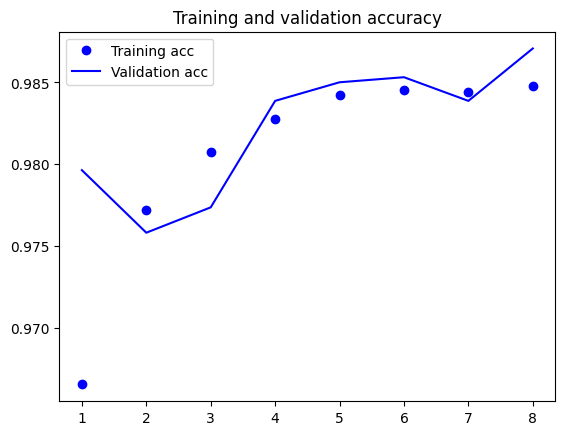

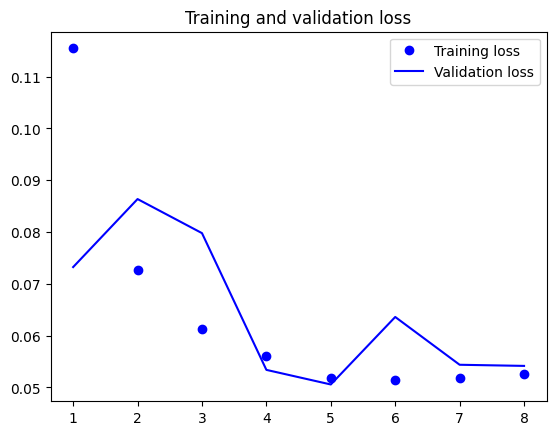

In [18]:
# Plot results
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [19]:
# Save the model as a file
models.save_model(model, model_filename)

In [20]:
# See which are 'stop'
for idx, y in enumerate(y_test):
    if y == 1:
        print(idx)

11
25
48
70
83
90
95
123
146
187
229
238
251
305
326
353
372
405
437
440
451
453
466
468
473
480
535
540
606
677
692
704
747
771
796
818
858
860
902
1037
1108
1203
1204
1230
1262
1268
1288
1304
1363
1518
1528
1533
1534
1550
1595
1602
1625
1668
1671
1692
1702
1715
1718
1724
1745
1746
1778
1795
1811
1821
1835
1840
1841
1872
1918
1928
1952
2046
2111
2130
2151
2174
2190
2194
2204
2221
2226
2236
2237
2241
2266
2284
2290
2296
2321
2414
2427
2434
2473
2499
2530
2546
2578
2600
2633
2634
2657
2742
2748
2828
2855
2866
2914
2951
2952
2986
3080
3090
3102
3117
3122
3144
3173
3187
3188
3209
3282
3284
3302
3314
3338
3352
3355
3397
3412
3437
3453
3462
3483
3564
3567
3602
3766
3861
3905
3939
3959
3963
4020
4059
4100
4104
4132
4164
4168
4181
4192
4204
4215
4254
4259
4270
4336
4347
4353
4381
4386
4405
4420
4447
4448
4450
4462
4484
4494
4510
4585
4710
4769
4784
4820
4836
4926
4940
4971
4975
4980
5005
5016
5020
5057
5108
5187
5195
5207
5213
5234
5265
5300
5305
5346
5352
5372
5373
5401
5428
5438
5478
5526
5

In [21]:
# TEST: Load model and run it against test set
model = models.load_model(model_filename)
for i in range(100, 110):
    print('Answer:', y_test[i], ' Prediction:', model.predict(np.expand_dims(x_test[i], 0)))

Answer: 0.0  Prediction: [[0.00018022]]
Answer: 0.0  Prediction: [[2.1098183e-21]]
Answer: 0.0  Prediction: [[8.325199e-07]]
Answer: 0.0  Prediction: [[0.03403303]]
Answer: 0.0  Prediction: [[6.1589423e-12]]
Answer: 0.0  Prediction: [[0.00746522]]
Answer: 0.0  Prediction: [[2.9688242e-06]]
Answer: 0.0  Prediction: [[6.229349e-07]]
Answer: 0.0  Prediction: [[2.9920914e-14]]
Answer: 0.0  Prediction: [[0.01680346]]


In [22]:
# Evaluate model with test set
model.evaluate(x=x_test, y=y_test)

303/303 [==============================] - 1s 2ms/step - loss: 0.0551 - acc: 0.9872


[0.05506684631109238, 0.987201988697052]